# CNN 2D con Domain Adaptation - Ibarra et al. (2023)
## Modelo con GRL - Train/Val/Test Split

Este notebook entrena un modelo **CNN2D_DA** (con Domain Adaptation) para clasificación binaria Parkinson vs Healthy.

### Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos preprocesados (sin augmentation)
3. **Split**: Train/Val/Test estratificado (70/15/15)
4. **Model**: CNN2D_DA (dual-head con Gradient Reversal Layer)
5. **Training**: Entrenamiento multi-task con early stopping
6. **Evaluation**: Métricas completas en test set
7. **Visualization**: Gráficas de progreso y resultados

### Prerequisito:
**Ejecutar primero `data_preprocessing.ipynb`** para generar el cache de espectrogramas individuales (65×41).

### Comparación:
- **Este notebook**: Modelo CNN2D_DA con Domain Adaptation
- **cnn_training.ipynb**: Modelo baseline CNN2D sin DA

### Referencia:
Ibarra et al. (2023): "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"

Preprocesamiento exacto según paper (sin augmentation).


## 1. Setup y Configuración


In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.data.augmentation import create_augmented_dataset
from modules.core.dataset import to_pytorch_tensors
from modules.models.cnn2d.model import CNN2D_DA
from modules.models.cnn2d.training import train_model_da, evaluate_da
from modules.models.cnn2d.visualization import plot_da_training_progress
from modules.models.cnn2d.utils import plot_confusion_matrix, compute_class_weights_auto, print_model_architecture

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("🧠 CNN 2D-DA TRAINING (con Domain Adaptation)")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print("="*70)


🧠 CNN 2D-DA TRAINING (con Domain Adaptation)
✅ Librerías cargadas correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu


## 2. Carga de Datos desde Cache

Prerequisito: Ejecutar primero `data_preprocessing.ipynb` para generar espectrogramas sin augmentation.


In [ ]:
# ============================================================
# CARGA DE DATOS - IBARRA ET AL. (2023)
# ============================================================

from modules.core.dataset import load_spectrograms_cache, to_pytorch_tensors

CACHE_HEALTHY = "./cache/healthy_ibarra.pkl"
CACHE_PARKINSON = "./cache/parkinson_ibarra.pkl"

print("="*70)
print("CARGANDO DATOS (IBARRA 2023 - SIN AUGMENTATION)")
print("="*70)

# Cargar Healthy
dataset_healthy = load_spectrograms_cache(CACHE_HEALTHY)
if dataset_healthy is None:
    raise FileNotFoundError(
        f"Cache no encontrado: {CACHE_HEALTHY}\n"
        f"Ejecutar primero data_preprocessing.ipynb"
    )

X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(dataset_healthy)
print(f"🟢 Healthy: {X_healthy.shape[0]} espectrogramas")

# Cargar Parkinson
dataset_parkinson = load_spectrograms_cache(CACHE_PARKINSON)
if dataset_parkinson is None:
    raise FileNotFoundError(
        f"Cache no encontrado: {CACHE_PARKINSON}\n"
        f"Ejecutar primero data_preprocessing.ipynb"
    )

X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(dataset_parkinson)
print(f"🔴 Parkinson: {X_parkinson.shape[0]} espectrogramas")

# Combinar datasets
X_combined = torch.cat([X_healthy, X_parkinson], dim=0)
y_task_combined = torch.cat([
    torch.zeros(len(X_healthy), dtype=torch.long),
    torch.ones(len(X_parkinson), dtype=torch.long)
], dim=0)

# Ajustar dominios para evitar colisiones
max_domain_hc = y_domain_healthy.max().item()
y_domain_combined = torch.cat([
    y_domain_healthy,
    y_domain_parkinson + max_domain_hc + 1
], dim=0)

print(f"\n📊 Dataset combinado: {len(X_combined)} espectrogramas")
print(f"   • Dominios únicos: {len(torch.unique(y_domain_combined))}")
print(f"   • Preprocesamiento: sin augmentation (paper)")
print("="*70)


📁 CARGANDO DATOS DESDE CACHE
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)
🟢 Healthy: 1553 muestras
💾 Cargando dataset desde cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1219 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)
🔴 Parkinson: 1219 muestras

📊 Dataset combinado: 2772 muestras
   • Dominios únicos: 26


## 3. Split Train/Val/Test


In [3]:
# ============================================================
# SPLIT Y DATALOADERS
# ============================================================

print("="*70)
print("📊 SPLIT TRAIN/VAL/TEST")
print("="*70)

# Split train/val/test (70/15/15)
X_train_val, X_test, y_task_train_val, y_task_test, y_domain_train_val, y_domain_test = train_test_split(
    X_combined, y_task_combined, y_domain_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_task_combined
)

X_train, X_val, y_task_train, y_task_val, y_domain_train, y_domain_val = train_test_split(
    X_train_val, y_task_train_val, y_domain_train_val,
    test_size=0.176,
    random_state=42,
    stratify=y_task_train_val
)

# Wrapper para formato de diccionario
class DictDataset(torch.utils.data.Dataset):
    def __init__(self, X, y_task, y_domain):
        self.X = X
        self.y_task = y_task
        self.y_domain = y_domain
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_task[idx], self.y_domain[idx]

# Crear datasets
train_dataset = DictDataset(X_train, y_task_train, y_domain_train)
val_dataset = DictDataset(X_val, y_task_val, y_domain_val)
test_dataset = DictDataset(X_test, y_task_test, y_domain_test)

# Crear DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"\n📊 Splits: Train={len(X_train)} | Val={len(X_val)} | Test={len(X_test)}")
print(f"✅ DataLoaders creados (batch_size={BATCH_SIZE})")
print("="*70)


📊 SPLIT TRAIN/VAL/TEST

📊 Splits: Train=1941 | Val=415 | Test=416
✅ DataLoaders creados (batch_size=32)


## 4. Crear Modelo CNN2D_DA

Modelo dual-head con Gradient Reversal Layer para Domain Adaptation.


In [4]:
# ============================================================
# CREAR MODELO CNN2D_DA
# ============================================================

print("="*70)
print("🏗️  CREANDO MODELO CNN2D_DA")
print("="*70)

# Número de dominios únicos
n_domains = len(torch.unique(y_domain_combined))

print(f"\n📊 Configuración:")
print(f"   • Dominios únicos: {n_domains}")
print(f"   • Clases PD: 2 (Healthy/Parkinson)")
print(f"   • Input shape: (B, 1, 65, 41)")

# Crear modelo
model_da = CNN2D_DA(
    n_domains=n_domains,
    p_drop_conv=0.3,
    p_drop_fc=0.5
).to(device)

print(f"\n✅ Modelo creado en device: {device}")

# Mostrar arquitectura
print_model_architecture(model_da, input_shape=(1, 1, 65, 41))


🏗️  CREANDO MODELO CNN2D_DA

📊 Configuración:
   • Dominios únicos: 26
   • Clases PD: 2 (Healthy/Parkinson)
   • Input shape: (B, 1, 65, 41)

✅ Modelo creado en device: cpu

🏗️  ARQUITECTURA DEL MODELO
CNN2D_DA(
  (feature_extractor): FeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (pd_head): ClassifierHe

In [5]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("⚙️  CONFIGURACIÓN DE ENTRENAMIENTO (IBARRA 2023)")
print("="*70)

# Hiperparámetros según paper
N_EPOCHS = 100
LEARNING_RATE = 0.1  # SGD según Ibarra
ALPHA = 1.0  # Peso de loss_domain
LAMBDA_CONSTANT = 1.0  # Lambda constante para GRL
EARLY_STOPPING_PATIENCE = 15

# Calcular class weights automáticos
print("\n📊 Calculando class weights:")
pd_weights = compute_class_weights_auto(y_task_train, threshold=0.4)
domain_weights = compute_class_weights_auto(y_domain_train, threshold=0.4)

# Crear criterios
if pd_weights is not None:
    criterion_pd = nn.CrossEntropyLoss(weight=pd_weights.to(device))
else:
    criterion_pd = nn.CrossEntropyLoss()

if domain_weights is not None:
    criterion_domain = nn.CrossEntropyLoss(weight=domain_weights.to(device))
else:
    criterion_domain = nn.CrossEntropyLoss()

# Optimizer SGD con LR 0.1 (Ibarra 2023)
optimizer = torch.optim.SGD(
    model_da.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=1e-4
)

# LR Scheduler: StepLR
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.1
)

# Lambda scheduler constante
lambda_scheduler = lambda epoch: LAMBDA_CONSTANT

# Directorio para guardar
save_dir = Path("./results/cnn_da")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📋 Configuración:")
print(f"   • Épocas máximas: {N_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE} (SGD)")
print(f"   • LR Scheduler: StepLR (step=30, gamma=0.1)")
print(f"   • Lambda GRL: {LAMBDA_CONSTANT} (constante)")
print(f"   • Alpha (peso dominio): {ALPHA}")
print(f"   • Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   • Save dir: {save_dir}")
print("="*70)



⚙️  CONFIGURACIÓN DE ENTRENAMIENTO (IBARRA 2023)

📊 Calculando class weights:
   ✓ Dataset balanceado (min class: 44.0%). Sin pesos.
   ⚠️  Desbalance detectado (min class: 0.3%). Aplicando pesos.

📋 Configuración:
   • Épocas máximas: 100
   • Learning rate: 0.1 (SGD)
   • LR Scheduler: StepLR (step=30, gamma=0.1)
   • Lambda GRL: 1.0 (constante)
   • Alpha (peso dominio): 1.0
   • Early stopping: 15 épocas
   • Save dir: results\cnn_da


## 5. Entrenamiento Multi-task

Entrenar con Domain Adaptation (PD + Domain classification).


In [6]:
# ============================================================
# ENTRENAR MODELO CON DOMAIN ADAPTATION
# ============================================================

print("\n" + "="*70)
print("🚀 INICIANDO ENTRENAMIENTO CON DOMAIN ADAPTATION")
print("="*70)

training_results_da = train_model_da(
    model=model_da,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    n_epochs=N_EPOCHS,
    alpha=ALPHA,
    lambda_scheduler=lambda_scheduler,
    lr_scheduler=lr_scheduler,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=save_dir,
    verbose=True
)

# Extraer resultados
model_da = training_results_da["model"]
history_da = training_results_da["history"]
best_val_loss_pd = training_results_da["best_val_loss_pd"]
total_time = training_results_da["total_time"]

# Calcular mejor época
best_epoch = history_da["val_loss_pd"].index(min(history_da["val_loss_pd"])) + 1

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"\n📊 Resultados:")
print(f"   • Mejor época: {best_epoch}")
print(f"   • Mejor val loss PD: {best_val_loss_pd:.4f}")
print(f"   • Tiempo total: {total_time/60:.1f} minutos")
print(f"   • Modelo guardado en: {save_dir / 'best_model_da.pth'}")
print("="*70)



🚀 INICIANDO ENTRENAMIENTO CON DOMAIN ADAPTATION

INICIO DE ENTRENAMIENTO CON DOMAIN ADAPTATION
Épocas máximas: 100
Early stopping patience: 15
Alpha (peso dominio): 1.0
Device: cpu

Época   1/100 | λ=1.000 | Train: L_PD=2.1239 L_Dom=14.7699 | Val: L_PD=0.6856 F1=0.0000 | 11.7s
Época   2/100 | λ=1.000 | Train: L_PD=0.6904 L_Dom=3.2966 | Val: L_PD=0.6873 F1=0.0000 | 13.1s
Época   3/100 | λ=1.000 | Train: L_PD=0.6882 L_Dom=3.2983 | Val: L_PD=0.6944 F1=0.6097 | 8.5s
Época   4/100 | λ=1.000 | Train: L_PD=0.6928 L_Dom=3.3043 | Val: L_PD=0.6906 F1=0.0000 | 7.4s
Época   5/100 | λ=1.000 | Train: L_PD=0.6871 L_Dom=3.2829 | Val: L_PD=0.6903 F1=0.0000 | 6.8s
Época   6/100 | λ=1.000 | Train: L_PD=0.6895 L_Dom=3.3038 | Val: L_PD=0.6918 F1=0.0000 | 8.7s
Época   7/100 | λ=1.000 | Train: L_PD=0.6906 L_Dom=3.2863 | Val: L_PD=0.6856 F1=0.0000 | 8.7s
Época   8/100 | λ=1.000 | Train: L_PD=0.6956 L_Dom=3.2947 | Val: L_PD=0.6897 F1=0.0000 | 8.0s
Época   9/100 | λ=1.000 | Train: L_PD=0.6876 L_Dom=3.2868 | Va

## 6. Evaluación

Evaluar el modelo en test set (ambas tareas: PD y Domain).


In [7]:
# ============================================================
# EVALUACIÓN EN TEST SET
# ============================================================

print("\n" + "="*70)
print("🎯 EVALUACIÓN EN TEST SET")
print("="*70)

# Evaluar modelo DA
test_metrics_da = evaluate_da(
    model=model_da,
    loader=test_loader,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    alpha=ALPHA
)

print(f"\n📊 MÉTRICAS EN TEST:")
print(f"   • Loss PD: {test_metrics_da['loss_pd']:.4f}")
print(f"   • Loss Domain: {test_metrics_da['loss_domain']:.4f}")
print(f"   • Loss Total: {test_metrics_da['loss_total']:.4f}")
print(f"   • Accuracy PD: {test_metrics_da['acc_pd']:.4f}")
print(f"   • F1 PD: {test_metrics_da['f1_pd']:.4f}")
print(f"   • Precision PD: {test_metrics_da['precision_pd']:.4f}")
print(f"   • Recall PD: {test_metrics_da['recall_pd']:.4f}")
print(f"   • Accuracy Domain: {test_metrics_da['acc_domain']:.4f}")

# Obtener predicciones para matriz de confusión
model_da.eval()
all_preds_pd = []
all_labels_pd = []

with torch.no_grad():
    for batch in test_loader:
        specs, labels_pd, labels_domain = batch
        specs = specs.to(device)
        
        logits_pd, _ = model_da(specs)
        preds = logits_pd.argmax(dim=1)
        
        all_preds_pd.extend(preds.cpu().numpy())
        all_labels_pd.extend(labels_pd.numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels_pd, all_preds_pd)

print(f"\n📊 MATRIZ DE CONFUSIÓN:")
print(f"              Pred HC  Pred PD")
print(f"Real HC       {cm[0, 0]:7d}  {cm[0, 1]:7d}")
print(f"Real PD       {cm[1, 0]:7d}  {cm[1, 1]:7d}")

# Guardar métricas
import json
metrics_path = save_dir / "test_metrics_da.json"
with open(metrics_path, "w") as f:
    json.dump({
        "loss_pd": float(test_metrics_da['loss_pd']),
        "loss_domain": float(test_metrics_da['loss_domain']),
        "loss_total": float(test_metrics_da['loss_total']),
        "acc_pd": float(test_metrics_da['acc_pd']),
        "f1_pd": float(test_metrics_da['f1_pd']),
        "precision_pd": float(test_metrics_da['precision_pd']),
        "recall_pd": float(test_metrics_da['recall_pd']),
        "acc_domain": float(test_metrics_da['acc_domain']),
        "confusion_matrix": cm.tolist()
    }, f, indent=2)

print(f"\n💾 Métricas guardadas en: {metrics_path}")
print("="*70)



🎯 EVALUACIÓN EN TEST SET

📊 MÉTRICAS EN TEST:
   • Loss PD: 0.6949
   • Loss Domain: 3.3252
   • Loss Total: 4.0202
   • Accuracy PD: 0.5601
   • F1 PD: 0.0000
   • Precision PD: 0.0000
   • Recall PD: 0.0000
   • Accuracy Domain: 0.0048

📊 MATRIZ DE CONFUSIÓN:
              Pred HC  Pred PD
Real HC           233        0
Real PD           183        0

💾 Métricas guardadas en: results\cnn_da\test_metrics_da.json


## 7. Visualización



📊 VISUALIZACIÓN
💾 Gráfica guardada en: results\cnn_da\training_progress_da.png


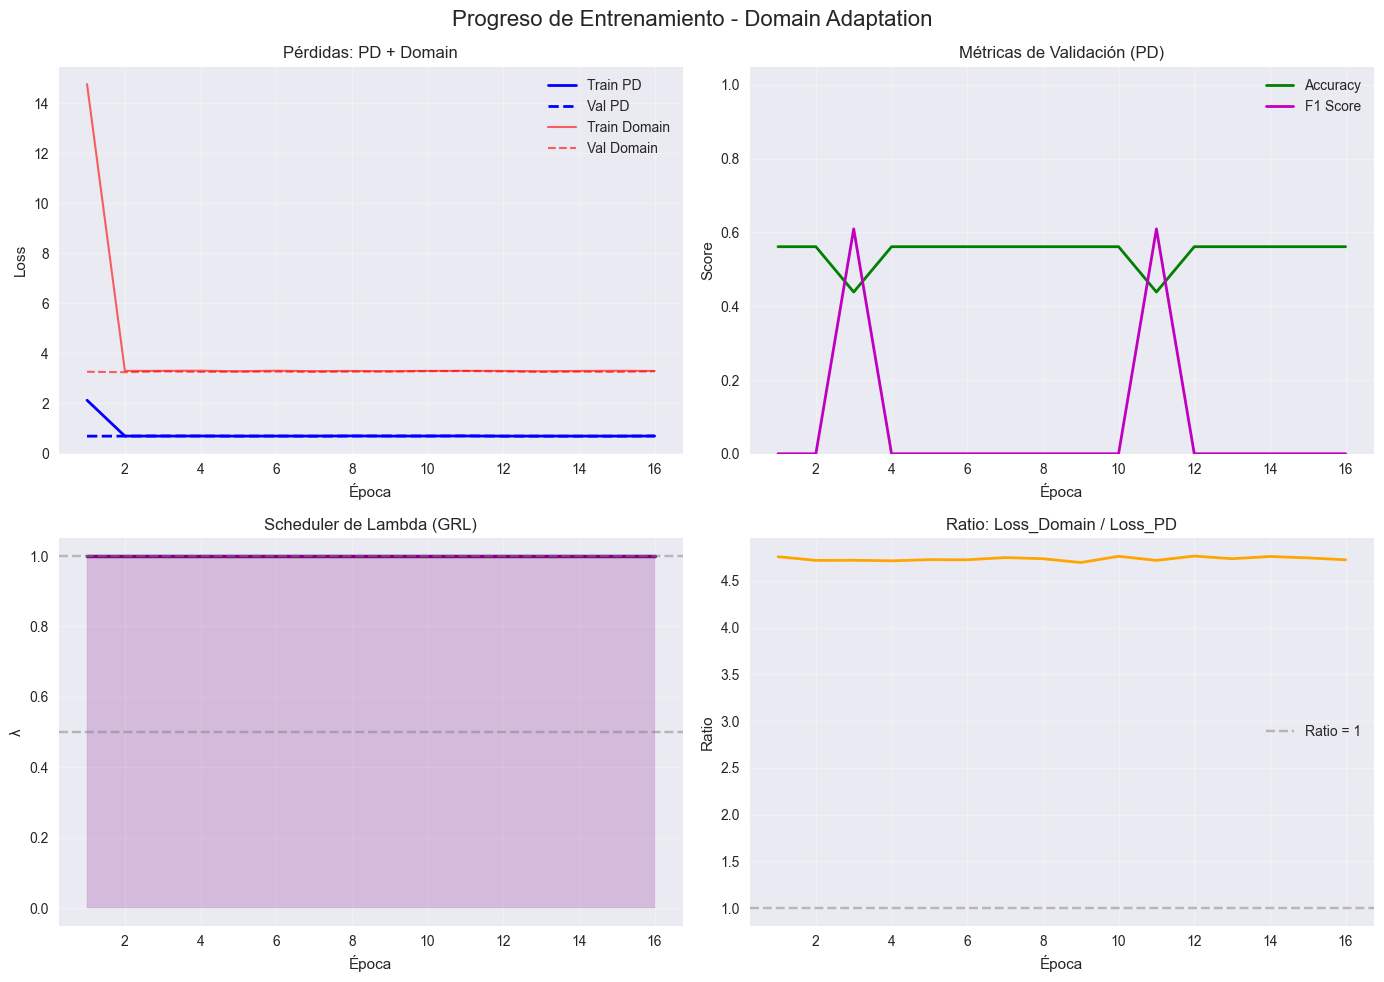

✅ Gráfica de progreso guardada en: results\cnn_da\training_progress_da.png


In [8]:
# ============================================================
# VISUALIZACIÓN: PROGRESO DE ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN")
print("="*70)

# Graficar progreso multi-task
fig_progress = plot_da_training_progress(
    history_da,
    save_path=save_dir / "training_progress_da.png",
    show=True
)

print(f"✅ Gráfica de progreso guardada en: {save_dir / 'training_progress_da.png'}")


💾 Matriz guardada en: results\cnn_da\confusion_matrix_test_da.png


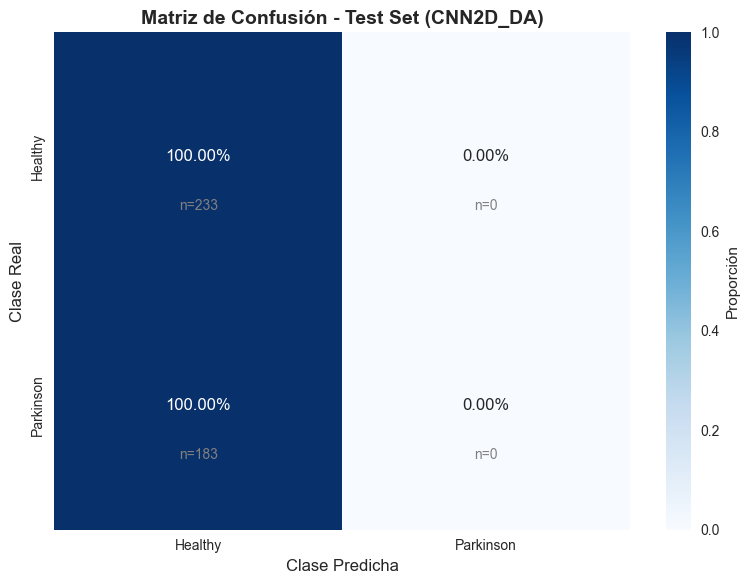


✅ Matriz de confusión guardada en: results\cnn_da\confusion_matrix_test_da.png


In [9]:
# ============================================================
# VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
# ============================================================

fig_cm = plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN2D_DA)",
    save_path=save_dir / "confusion_matrix_test_da.png",
    show=True
)

print(f"\n✅ Matriz de confusión guardada en: {save_dir / 'confusion_matrix_test_da.png'}")


## 📋 Resumen Final

### ✅ Completado:
1. **Datos**: Cargados desde cache (augmentados)
2. **Split**: Train/Val/Test estratificado (70/15/15)
3. **Modelo**: CNN2D_DA con Domain Adaptation y GRL
4. **Training**: Multi-task con early stopping
5. **Evaluation**: Métricas para PD y Domain
6. **Visualización**: Progreso multi-task y matriz de confusión

### 📊 Resultados Guardados:
- Modelo: `results/cnn_da/best_model_da.pth`
- Métricas: `results/cnn_da/test_metrics_da.json`
- Gráficas: `results/cnn_da/training_progress_da.png`, `confusion_matrix_test_da.png`

### 🔄 Comparación con CNN2D:
- **Este modelo**: CNN2D_DA con Domain Adaptation
- **Baseline** (en `cnn_training.ipynb`): CNN2D simple sin DA

### 🚀 Próximos Pasos (Futuro):
1. **MC Dropout**: Implementar inferencia con MC Dropout
2. **Comparación**: Comparar resultados entre CNN2D y CNN2D_DA
3. **K-fold**: Usar `pipelines/train_cnn_da_kfold.py` para validación robusta


In [10]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*70)
print("📋 RESUMEN FINAL")
print("="*70)

print(f"\n🎯 MODELO: CNN2D_DA (con Domain Adaptation)")
print(f"\n📊 DATASET:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"   • Dominios: {n_domains}")

print(f"\n🏆 MEJOR MODELO (Época {best_epoch}):")
print(f"   • Val Loss PD: {best_val_loss_pd:.4f}")

print(f"\n🎯 MÉTRICAS EN TEST SET:")
print(f"   • Accuracy PD:  {test_metrics_da['acc_pd']:.4f}")
print(f"   • Precision PD: {test_metrics_da['precision_pd']:.4f}")
print(f"   • Recall PD:    {test_metrics_da['recall_pd']:.4f}")
print(f"   • F1-Score PD:  {test_metrics_da['f1_pd']:.4f}")

print(f"\n📁 Archivos guardados en: {save_dir}")
print(f"   ✓ best_model_da.pth")
print(f"   ✓ test_metrics_da.json")
print(f"   ✓ training_progress_da.png")
print(f"   ✓ confusion_matrix_test_da.png")

print("\n" + "="*70)
print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("="*70)



📋 RESUMEN FINAL

🎯 MODELO: CNN2D_DA (con Domain Adaptation)

📊 DATASET:
   • Total muestras: 2772
   • Train: 1941 | Val: 415 | Test: 416
   • Dominios: 26

🏆 MEJOR MODELO (Época 1):
   • Val Loss PD: 0.6856

🎯 MÉTRICAS EN TEST SET:
   • Accuracy PD:  0.5601
   • Precision PD: 0.0000
   • Recall PD:    0.0000
   • F1-Score PD:  0.0000

📁 Archivos guardados en: results\cnn_da
   ✓ best_model_da.pth
   ✓ test_metrics_da.json
   ✓ training_progress_da.png
   ✓ confusion_matrix_test_da.png

✅ PIPELINE COMPLETADO EXITOSAMENTE
